In [1]:
%cd ..

/Users/bdhammel/Documents/insight/harvesting


In [9]:
%matplotlib inline 

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)

import matplotlib.pyplot as plt
from models.retinanet.keras_retinanet.models.retinanet import custom_objects
import pipeline.utils as pipe_utils
from skimage.transform import resize as skresize
from pipeline.raw_data import clean_dota
from PIL import Image, ImageDraw
import glob
import os
import csv
import keras

SNAPSHOT_DIR = os.path.join(os.getcwd(), 'models/saved_models')
IMAGE_DIR = os.path.join(os.getcwd(), 'datasets/raw_images')

MAP_ID_TO_LABEL = {}
with open('datasets/obj_detection/dota/classes.csv', 'r') as f:
    csvreader = csv.reader(f)
    for row in csvreader:
        label, id_ = row
        MAP_ID_TO_LABEL[int(id_)] = label        

In [3]:
model_path = os.path.join(SNAPSHOT_DIR, 'trained_full.h5')
model = keras.models.load_model(model_path, custom_objects=custom_objects)

/usr/local/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


Image test11.png loaded
	Shape:  (400, 400, 3)
	dtype:  uint8
Values: (65.00,255.00)


(-0.5, 399.5, 399.5, -0.5)

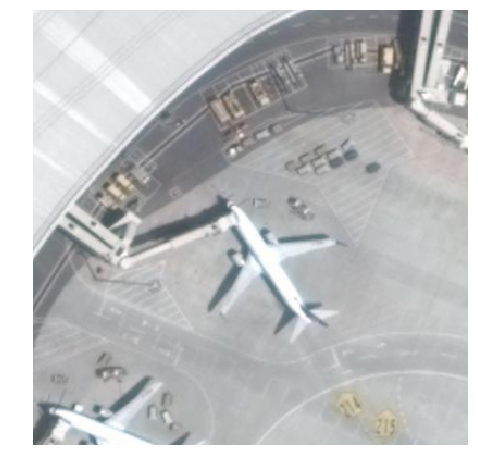

In [4]:
image_path = os.path.join(IMAGE_DIR, 'test11.png')
data = pipe_utils.read_raw_image(image_path)
data = skresize(data, (400,400,3), mode='reflect', preserve_range=True)
plt.figure(figsize=(8,8))
plt.imshow(data/255)
plt.axis('off')

In [5]:
# Preprocess for RetinaNet
X = np.copy(data[...,::-1])
X = X.reshape((-1,400,400,3))
X[...,0] -= 103.939
X[...,1] -= 116.779
X[...,2] -= 123.68

In [6]:
predictions = model.predict(X)
*_, detections = predictions

In [7]:
threshold=.4
objs = []
for potential_obj in detections[0]:
    if np.any(potential_obj[4:]>threshold):
        objs.append(potential_obj)
objs = np.asarray(objs)
obj_labels = [MAP_ID_TO_LABEL[id_] for id_ in np.argmax(objs[:,4:], axis=1)]

In [12]:
print("{} objects found in the image".format(len(objs)))
print("Found: ")
for obj in obj_labels:
    print("\t", obj)

1 objects found in the image
Found: 
	 plane


(-0.5, 399.5, 399.5, -0.5)

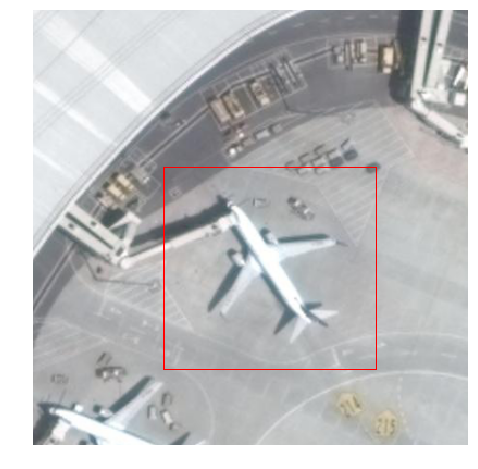

In [11]:
plt.figure(figsize=(8,8))
img = Image.fromarray(data.astype(np.uint8))
draw = ImageDraw.Draw(img) 
for obj in objs:
    draw.rectangle(
        obj[:4],
        outline='red'
    )

plt.imshow(np.asarray(img))
plt.axis('off')